In [1]:
import random
from collections import Counter
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import isnan
from numpy import mean
from numpy import std
from numpy import loadtxt
from numpy import sort
from matplotlib import pyplot
import matplotlib.pyplot as plt
import graphviz 
from graphviz import Digraph
from sklearn import tree
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as skl_lm
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import xgboost 
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv("Myocardial.csv", header=0, na_values='?') 

In [3]:
# summarize first rows
print(dataframe.head())

    AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  IBS_NASL   GB  \
0  77.0    1       2.0        1.0        1.0       2.0       NaN  3.0   
1  55.0    1       1.0        0.0        0.0       0.0       0.0  0.0   
2  52.0    1       0.0        0.0        0.0       2.0       NaN  2.0   
3  68.0    0       0.0        0.0        0.0       2.0       NaN  2.0   
4  60.0    1       0.0        0.0        0.0       2.0       NaN  3.0   

   SIM_GIPERT  DLIT_AG  ...  NOT_NA_2_n  NOT_NA_3_n  LID_S_n  B_BLOK_S_n  \
0         0.0      7.0  ...         0.0         0.0      1.0         0.0   
1         0.0      0.0  ...         0.0         0.0      1.0         0.0   
2         0.0      2.0  ...         2.0         2.0      1.0         1.0   
3         0.0      3.0  ...         0.0         0.0      0.0         0.0   
4         0.0      7.0  ...         0.0         0.0      0.0         0.0   

   ANT_CA_S_n  GEPAR_S_n  ASP_S_n  TIKL_S_n  TRENT_S_n  Compl  
0         0.0        1.0      1.0       

In [4]:
# missing values per column (# selected column threshold: 30%)
column_list = []
for i in range(dataframe.shape[1]):
    n_miss = dataframe.iloc[:,i].isnull().sum()
    perc = n_miss / dataframe.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
    if perc >= 30:
        column_list.append(i)

> 0, Missing: 8 (0.5%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 4 (0.2%)
> 3, Missing: 106 (6.2%)
> 4, Missing: 73 (4.3%)
> 5, Missing: 51 (3.0%)
> 6, Missing: 1628 (95.8%)
> 7, Missing: 9 (0.5%)
> 8, Missing: 8 (0.5%)
> 9, Missing: 248 (14.6%)
> 10, Missing: 54 (3.2%)
> 11, Missing: 21 (1.2%)
> 12, Missing: 21 (1.2%)
> 13, Missing: 21 (1.2%)
> 14, Missing: 21 (1.2%)
> 15, Missing: 21 (1.2%)
> 16, Missing: 21 (1.2%)
> 17, Missing: 21 (1.2%)
> 18, Missing: 18 (1.1%)
> 19, Missing: 18 (1.1%)
> 20, Missing: 18 (1.1%)
> 21, Missing: 18 (1.1%)
> 22, Missing: 18 (1.1%)
> 23, Missing: 18 (1.1%)
> 24, Missing: 18 (1.1%)
> 25, Missing: 11 (0.6%)
> 26, Missing: 10 (0.6%)
> 27, Missing: 10 (0.6%)
> 28, Missing: 7 (0.4%)
> 29, Missing: 7 (0.4%)
> 30, Missing: 7 (0.4%)
> 31, Missing: 7 (0.4%)
> 32, Missing: 7 (0.4%)
> 33, Missing: 1076 (63.3%)
> 34, Missing: 1076 (63.3%)
> 35, Missing: 267 (15.7%)
> 36, Missing: 267 (15.7%)
> 37, Missing: 12 (0.7%)
> 38, Missing: 15 (0.9%)
> 39, Missing: 14 (0.8%)
> 40

In [5]:
# drop rows with missing values
dataframe_col_name = dataframe.columns
dataframe_col_name_delete= dataframe_col_name[column_list]
dataframe.drop(dataframe_col_name_delete, axis=1, inplace=True)

In [6]:
dataframe.to_csv('Myocardial_2.csv')

In [7]:
dataframe_2 = pd.read_csv("Myocardial_2.csv", index_col = 0, na_values='?')

In [8]:
# missing values per row (selected column threshold: 30%)
row_list = []
for i in range(dataframe_2.shape[0]):
    n_miss = dataframe_2.iloc[i].isnull().sum()
    perc = n_miss / dataframe_2.shape[1] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
    if perc >= 30:
        row_list.append(i)

> 0, Missing: 2 (1.9%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 1 (1.0%)
> 3, Missing: 2 (1.9%)
> 4, Missing: 1 (1.0%)
> 5, Missing: 4 (3.8%)
> 6, Missing: 4 (3.8%)
> 7, Missing: 2 (1.9%)
> 8, Missing: 8 (7.6%)
> 9, Missing: 4 (3.8%)
> 10, Missing: 0 (0.0%)
> 11, Missing: 0 (0.0%)
> 12, Missing: 4 (3.8%)
> 13, Missing: 0 (0.0%)
> 14, Missing: 0 (0.0%)
> 15, Missing: 2 (1.9%)
> 16, Missing: 4 (3.8%)
> 17, Missing: 1 (1.0%)
> 18, Missing: 8 (7.6%)
> 19, Missing: 0 (0.0%)
> 20, Missing: 2 (1.9%)
> 21, Missing: 0 (0.0%)
> 22, Missing: 0 (0.0%)
> 23, Missing: 4 (3.8%)
> 24, Missing: 6 (5.7%)
> 25, Missing: 4 (3.8%)
> 26, Missing: 4 (3.8%)
> 27, Missing: 1 (1.0%)
> 28, Missing: 1 (1.0%)
> 29, Missing: 0 (0.0%)
> 30, Missing: 8 (7.6%)
> 31, Missing: 0 (0.0%)
> 32, Missing: 6 (5.7%)
> 33, Missing: 4 (3.8%)
> 34, Missing: 6 (5.7%)
> 35, Missing: 2 (1.9%)
> 36, Missing: 0 (0.0%)
> 37, Missing: 6 (5.7%)
> 38, Missing: 2 (1.9%)
> 39, Missing: 2 (1.9%)
> 40, Missing: 4 (3.8%)
> 41, Missing: 2 (1.9%)
> 

In [9]:
dataframe_2.drop(row_list,axis=0,inplace=True)

In [10]:
dataframe_2.to_csv('Myocardial_3.csv')

In [11]:
X = dataframe_2.iloc[:, 0:104]
y = dataframe_2.iloc[:, 104]

In [12]:
# create list of binary variables
binary_list = []
for i in range(len(X.iloc[0])):
    if X.iloc[:,i].max() == 1:
        binary_list.append(i)

In [13]:
# create list of continuous variables
continuous_list = [0,32,33,79,81,82,83,84,85]

# create list of all variables
listt = [*range(104)]

In [14]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [15]:
# create list of categorical variables 
binary_categorical = Diff(listt, continuous_list)
categorical_list = Diff(binary_categorical,binary_list)

In [16]:
# convert binary to boolean
for i in range(len(X.columns[binary_list])):
    X[X.columns[binary_list][i]] = X[X.columns[binary_list][i]].astype('bool')
X[X.columns[binary_list]]
X_binary = X[X.columns[binary_list]]

binary_name = X_binary.columns

In [17]:
# convert continuous to float    
for i in range(len(X.columns[continuous_list])):
    X[X.columns[continuous_list][i]] = X[X.columns[continuous_list][i]].astype('float')
X[X.columns[continuous_list]]
X_continuous = X[X.columns[continuous_list]]

cont_name = X_continuous.columns

In [18]:
# convert categorical to integer   
for i in range(len(X.columns[categorical_list])):
    X[X.columns[categorical_list][i]] = X[X.columns[categorical_list][i]].astype('float')
X[X.columns[categorical_list]]
X_categorical = X[X.columns[categorical_list]]

catg_name = X_categorical.columns

In [19]:
# impute binary variables 
imputer = KNNImputer(n_neighbors=5)
imputer=imputer.fit(X_binary)

# convert to array
X_binary = imputer.transform(X_binary)
X_binary = pd.DataFrame(X_binary)
X_binary.columns = binary_name
X_binary.to_csv('Myocardial_binary.csv',sep=",")
# check null values
X_binary.isnull().sum(axis = 0)

SEX           0
SIM_GIPERT    0
nr_11         0
nr_01         0
nr_02         0
             ..
ANT_CA_S_n    0
GEPAR_S_n     0
ASP_S_n       0
TIKL_S_n      0
TRENT_S_n     0
Length: 74, dtype: int64

In [20]:
# impute continuous variables
imputer = KNNImputer(n_neighbors=5)
imputer=imputer.fit(X_continuous)

X_continuous = imputer.transform(X_continuous)
X_continuous = pd.DataFrame(X_continuous)
X_continuous.to_csv('Myocardial_cont.csv',sep=",")
X_continuous.columns = cont_name
X_continuous.isnull().sum(axis = 0)

AGE          0
S_AD_ORIT    0
D_AD_ORIT    0
K_BLOOD      0
NA_BLOOD     0
ALT_BLOOD    0
AST_BLOOD    0
L_BLOOD      0
ROE          0
dtype: int64

In [21]:
# impute categorical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer=imputer.fit(X_categorical)

X_categorical = imputer.transform(X_categorical)
X_categorical = pd.DataFrame(X_categorical)
X_categorical.columns = catg_name
X_categorical.to_csv('Myocardial_catg.csv',sep=",")
print(X_categorical.isnull().sum(axis = 0))

INF_ANAM      0
STENOK_AN     0
FK_STENOK     0
IBS_POST      0
GB            0
DLIT_AG       0
ZSN_A         0
ant_im        0
lat_im        0
inf_im        0
post_im       0
TIME_B_S      0
R_AB_1_n      0
R_AB_2_n      0
R_AB_3_n      0
NA_R_1_n      0
NA_R_2_n      0
NA_R_3_n      0
NOT_NA_1_n    0
NOT_NA_2_n    0
NOT_NA_3_n    0
dtype: int64


In [22]:
# return columns of an array
def column(matrix, i):
    return [row[i] for row in matrix]

In [23]:
# encode categorical variables
X_cat = X_categorical.to_numpy()
encoded_dataframe = pd.get_dummies(column(X_cat,0))

for i in range(1,len(X_categorical.iloc[0])):
    encoded = pd.get_dummies(column(X_cat,i))
    encoded_dataframe = pd.concat([encoded_dataframe, encoded], axis=1)
    
categorical_names = [*np.arange(101)]
encoded_dataframe.columns = categorical_names
encoded_dataframe.to_csv('Myocardial_encoding.csv',sep=",")

In [24]:
# standardize continuous variables
for i in range(len(X_continuous.iloc[0])):
    X_continuous.iloc[:, i] = (X_continuous.iloc[:, i] - X_continuous.iloc[:, i].mean())/X_continuous.iloc[:, i].std()

# combine datasets
X_all_combined = pd.concat([X_continuous, encoded_dataframe, X_binary], axis=1)
X_all_combined.to_csv('Myocardial_2_v2.csv')
X_df = X_all_combined

In [25]:
counter = Counter(y)
print(counter)

Counter({1: 923, 0: 753})


In [26]:
random.seed(240)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify = y)

In [27]:
counter = Counter(y_train)
print(counter)

Counter({1: 738, 0: 602})


In [28]:
# decision tree 
# explore the number of selected features for RFE

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 21):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>2 0.501 (0.052)
>3 0.526 (0.042)
>4 0.526 (0.039)
>5 0.533 (0.051)
>6 0.545 (0.036)
>7 0.539 (0.043)
>8 0.550 (0.038)
>9 0.534 (0.041)
>10 0.567 (0.047)
>11 0.555 (0.043)
>12 0.559 (0.037)
>13 0.553 (0.037)
>14 0.572 (0.052)
>15 0.577 (0.046)
>16 0.566 (0.047)
>17 0.575 (0.031)
>18 0.573 (0.046)
>19 0.563 (0.038)
>20 0.581 (0.056)


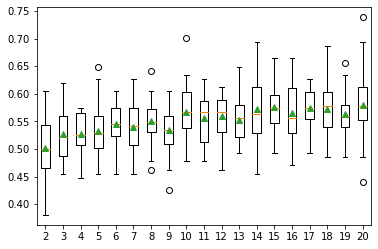

In [29]:
# get the models to evaluate
models = get_models()

X_train.columns = X_train.columns.map(str)

# evaluate models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [30]:
# report 10 features selected by RFE
rfe_10 = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe_10.fit(X_train, y_train)

# summarize all features
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_10.support_[i], rfe_10.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 91.000
Column: 10, Selected False, Rank: 12.000
Column: 11, Selected False, Rank: 49.000
Column: 12, Selected False, Rank: 55.000
Column: 13, Selected False, Rank: 62.000
Column: 14, Selected False, Rank: 15.000
Column: 15, Selected False, Rank: 100.000
Column: 16, Selected False, Rank: 109.000
Column: 17, Selected False, Rank: 66.000
Column: 18, Selected False, Rank: 101.000
Column: 19, Selected False, Rank: 79.000
Column: 20, Selected False, Rank: 25.000
Column: 21, Selected False, Rank: 89.000
Column: 22, Selected False, Rank: 113.000
Column: 23, Selected False, Rank: 112.000
Column: 24, Selected False, Rank: 53.00

In [31]:
# 10 selected features
DT_selected_list_10 = []
for i in range(X_train.shape[1]):
    if rfe_10.support_[i] == True:
        DT_selected_list_10.append(i)
X_train.columns[DT_selected_list_10]
X_train_10 = X_train[X_train.columns[DT_selected_list_10]]

In [32]:
# report 15 features selected by RFE
rfe_15 = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
rfe_15.fit(X_train, y_train)
# summarize all features
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_15.support_[i], rfe_15.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 37.000
Column: 10, Selected False, Rank: 7.000
Column: 11, Selected False, Rank: 47.000
Column: 12, Selected False, Rank: 53.000
Column: 13, Selected False, Rank: 54.000
Column: 14, Selected False, Rank: 15.000
Column: 15, Selected False, Rank: 79.000
Column: 16, Selected False, Rank: 106.000
Column: 17, Selected False, Rank: 80.000
Column: 18, Selected False, Rank: 76.000
Column: 19, Selected False, Rank: 87.000
Column: 20, Selected False, Rank: 84.000
Column: 21, Selected False, Rank: 110.000
Column: 22, Selected False, Rank: 10.000
Column: 23, Selected False, Rank: 112.000
Column: 24, Selected False, Rank: 50.000
C

In [33]:
# 15 selected features
DT_selected_list_15 = []
for i in range(X_train.shape[1]):
    if rfe_15.support_[i] == True:
        DT_selected_list_15.append(i)
DT_selected_list_15
X_train.columns[DT_selected_list_15]

Index(['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD',
       'AST_BLOOD', 'L_BLOOD', 'ROE', '17', '32', '86', 'zab_leg_02', 'NITR_S',
       'LID_S_n'],
      dtype='object')

In [34]:
X_train_15 = X_train[X_train.columns[DT_selected_list_15]]

In [35]:
# decision tree - hyperparameter tuning with all data
param_test1 = {
 'max_depth':range(2,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(DecisionTreeClassifier(),param_test1)              
grid.fit(X_train,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 2, 'min_samples_leaf': 10},0.5977611940298508) CHECK

({'mean_fit_time': array([0.00519981, 0.00449142, 0.00425735, 0.00422263, 0.0042202 ,
         0.00396843, 0.00422015, 0.00424967, 0.00424304, 0.0042356 ,
         0.00541644, 0.00537062, 0.00524702, 0.00526471, 0.00528827,
         0.00514326, 0.00522785, 0.00514083, 0.00501556, 0.00517035,
         0.00616913, 0.006249  , 0.00622201, 0.00612679, 0.00614371,
         0.00604343, 0.00597582, 0.00591826, 0.00606441, 0.0060008 ,
         0.00705609, 0.00695705, 0.00682974, 0.0067523 , 0.00677285,
         0.00666218, 0.00644879, 0.00664878, 0.00647449, 0.00661125,
         0.00790915, 0.00780244, 0.00758896, 0.00740948, 0.0072516 ,
         0.0073154 , 0.00717549, 0.00715747, 0.00695119, 0.00673146,
         0.0086988 , 0.00834322, 0.00827413, 0.00820231, 0.00784926,
         0.00775356, 0.00749526, 0.00739236, 0.00729437, 0.00710945,
         0.00952435, 0.00898094, 0.00874696, 0.0082684 , 0.00814323,
         0.00804257, 0.00768366, 0.00753007, 0.00719166, 0.00747313,
         0.010012

In [36]:
# decision tree - hyperparameter tuning with 10 features
param_test1 = {
 'max_depth':range(2,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(DecisionTreeClassifier(),param_test1)
                    
grid.fit(X_train_10,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 2, 'min_samples_leaf': 10},0.5977611940298508)

({'mean_fit_time': array([0.00188684, 0.00152879, 0.00159101, 0.00166488, 0.00157866,
         0.00160341, 0.00160508, 0.00157218, 0.00155516, 0.00156455,
         0.00186973, 0.00183315, 0.0019484 , 0.00191083, 0.00202308,
         0.00193086, 0.00197997, 0.00196114, 0.00190573, 0.00190258,
         0.00216513, 0.00221062, 0.00208941, 0.00227118, 0.00204711,
         0.00223403, 0.00204854, 0.00223708, 0.00211787, 0.00214109,
         0.00243578, 0.00257716, 0.00246124, 0.00246892, 0.00249138,
         0.00247631, 0.00235305, 0.00233321, 0.00237017, 0.00239935,
         0.00286565, 0.00286603, 0.0027842 , 0.00268636, 0.00263772,
         0.00254078, 0.00234919, 0.00238981, 0.00229635, 0.00237303,
         0.00298052, 0.00298676, 0.00281324, 0.00275025, 0.00271397,
         0.00263977, 0.00256228, 0.00250273, 0.00236063, 0.00253153,
         0.00328045, 0.00318899, 0.00306935, 0.00287905, 0.00283484,
         0.00270605, 0.00265026, 0.00252357, 0.00252724, 0.00245743,
         0.003299

In [37]:
# decision tree - hyperparameter tuning with 15 features
param_test1 = {
 'max_depth':range(3,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(DecisionTreeClassifier(),param_test1)                  
grid.fit(X_train_15,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 10, 'min_samples_leaf': 10}, 0.6074626865671642)

({'mean_fit_time': array([0.00205126, 0.0020472 , 0.00198474, 0.00199628, 0.00197797,
         0.00195537, 0.00191689, 0.00180664, 0.00181422, 0.00194821,
         0.00240326, 0.00237179, 0.00234003, 0.00235562, 0.00226908,
         0.00237007, 0.00233302, 0.00243092, 0.00240903, 0.00229831,
         0.00266552, 0.00265975, 0.00261436, 0.00263638, 0.0025928 ,
         0.00252781, 0.00253739, 0.00248361, 0.00248065, 0.00235462,
         0.00303545, 0.00293388, 0.00289459, 0.00282397, 0.00275035,
         0.00274243, 0.00263972, 0.00261817, 0.0026382 , 0.00259519,
         0.0030961 , 0.00321441, 0.00307355, 0.00297976, 0.00296206,
         0.00289164, 0.00277171, 0.00282993, 0.00276279, 0.00268579,
         0.00356545, 0.00329905, 0.00332947, 0.00315394, 0.00314121,
         0.00287457, 0.00285378, 0.0028574 , 0.0026659 , 0.00269022,
         0.00365124, 0.00342064, 0.0032949 , 0.0031817 , 0.00321794,
         0.00303311, 0.00296116, 0.00284185, 0.00269966, 0.00276365,
         0.003748

In [38]:
# predict with all features
clf_dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
clf_dt = clf_dt.fit(X_train,y_train)

X_test.columns = X_test.columns.map(str)
y_pred = clf_dt.predict(X_test)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6101190476190477
Precision: 0.6015037593984962
Recall: 0.8648648648648649
F-measure: 0.7095343680709534


In [39]:
# predict with 10 features
X_test_10 = X_test[X_test.columns[DT_selected_list_10]]

clf_dt_10 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=10)
clf_dt_10 = clf_dt_10.fit(X_train_10,y_train)
y_pred = clf_dt_10.predict(X_test_10)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

# confusion matrix
metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

Accuracy: 0.6041666666666666
Precision: 0.6007751937984496
Recall: 0.8378378378378378
F-measure: 0.6997742663656884


array([[ 48, 103],
       [ 30, 155]])

In [40]:
# predict with 15 features
X_test_15 = X_test[X_test.columns[DT_selected_list_15]]

clf_dt_15= DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)
clf_dt_15 = clf_dt_15.fit(X_train_15,y_train)
y_pred = clf_dt_15.predict(X_test_15)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6130952380952381
Precision: 0.6053639846743295
Recall: 0.8540540540540541
F-measure: 0.7085201793721975


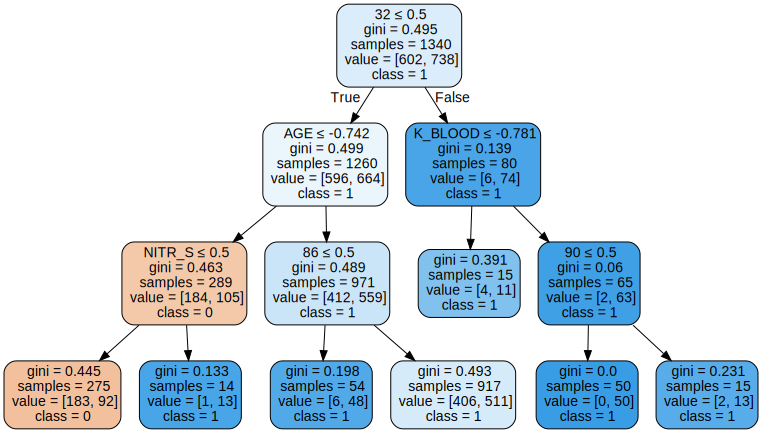

In [41]:
# create an iris.pdf file with the rule path
clf = clf_dt.fit(X_train,y_train)

column_names_full = X_train.columns

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=column_names_full,
                                class_names=["0","1"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("MI_full")
graph

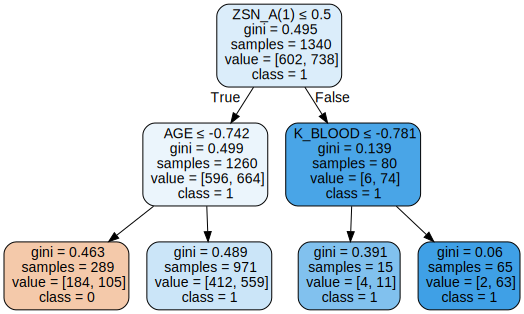

In [42]:
# 10 features 
clf = clf_dt_10.fit(X_train_10,y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=["AGE", "S_AD_ORIT", "D_AD_ORIT", "K_BLOOD", "NA_BLOOD", "ALT_BLOOD", "AST_BLOOD", "L_BLOOD", "ROE", "ZSN_A(1)"],
                                class_names=["0","1"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("MI_10")
graph

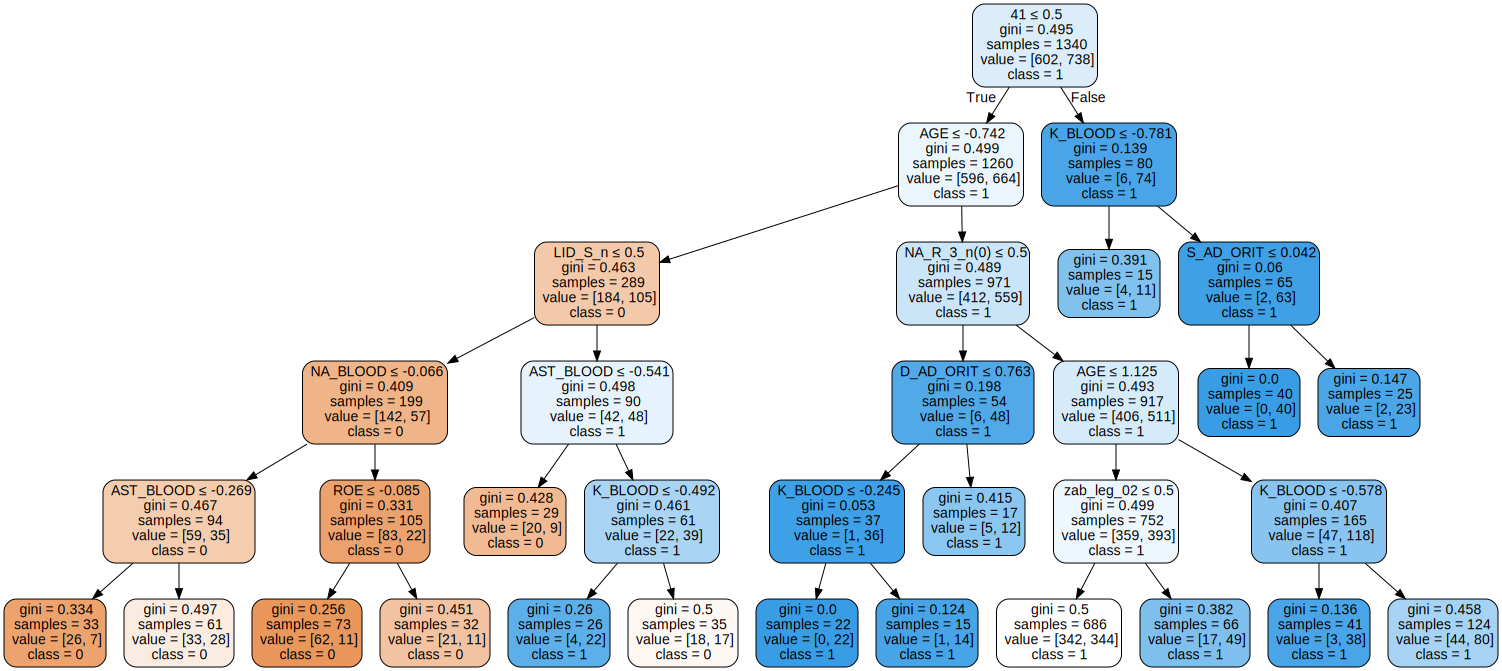

In [43]:
# 15 features
clf = clf_dt_15.fit(X_train_15,y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=["AGE", "S_AD_ORIT", "D_AD_ORIT", "K_BLOOD", "NA_BLOOD", "ALT_BLOOD", "AST_BLOOD", "L_BLOOD", "ROE", "CHF Stage 1","41","NA_R_3_n(0)","zab_leg_02","NITRS_S","LID_S_n"],
                                class_names=["0","1"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("MI_15")
graph

In [44]:
# random forest
# explore the number of selected features with RFE
def get_models():
    models = dict()
    for i in range(2, 21):
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i)
        model = RandomForestClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

def evaluate_model(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>2 0.530 (0.041)
>3 0.564 (0.040)
>4 0.568 (0.038)
>5 0.583 (0.030)
>6 0.592 (0.034)
>7 0.599 (0.040)
>8 0.585 (0.041)
>9 0.601 (0.034)
>10 0.601 (0.033)
>11 0.606 (0.037)
>12 0.608 (0.042)
>13 0.619 (0.047)
>14 0.620 (0.041)
>15 0.621 (0.040)
>16 0.620 (0.042)
>17 0.627 (0.049)
>18 0.626 (0.039)
>19 0.617 (0.045)
>20 0.631 (0.038)


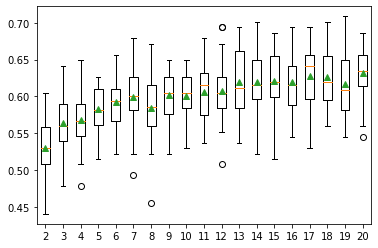

In [45]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [46]:
# report which features were selected by RFE with 10 features
rfe_10 = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe_10.fit(X_train, y_train)
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_10.support_[i], rfe_10.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 31.000
Column: 10, Selected False, Rank: 8.000
Column: 11, Selected False, Rank: 77.000
Column: 12, Selected False, Rank: 95.000
Column: 13, Selected False, Rank: 41.000
Column: 14, Selected False, Rank: 67.000
Column: 15, Selected False, Rank: 84.000
Column: 16, Selected False, Rank: 73.000
Column: 17, Selected False, Rank: 76.000
Column: 18, Selected False, Rank: 81.000
Column: 19, Selected False, Rank: 36.000
Column: 20, Selected False, Rank: 34.000
Column: 21, Selected False, Rank: 107.000
Column: 22, Selected False, Rank: 3.000
Column: 23, Selected False, Rank: 127.000
Column: 24, Selected False, Rank: 161.000
Co

In [47]:
# # 10 selected features
DT_selected_list_10 = []
for i in range(X_train.shape[1]):
    if rfe_10.support_[i] == True:
        DT_selected_list_10.append(i)
print(DT_selected_list_10)
X_train.columns[DT_selected_list_10]
X_train_10 = X_train[X_train.columns[DT_selected_list_10]]
X_train_10

[0, 1, 2, 3, 4, 5, 6, 7, 8, 41]


,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,32
1254,0.013855,-0.826343,-0.735813,0.739550,-0.099567,2.863236,3.417656,2.398220,-0.316492,0
466,1.614092,-0.618059,-0.735813,0.218125,0.573043,1.516641,-0.001798,-1.443778,0.146322,0
1310,-1.319675,0.215078,1.662403,0.884390,-0.267720,0.757449,-0.429230,-0.536220,-0.779305,0
335,-0.964067,-0.132062,-0.136259,2.912154,-0.099567,-0.489398,-0.803233,0.371339,-0.501617,0
293,1.525190,-0.548631,-0.376081,0.362965,-1.276635,-0.905014,-0.803233,0.159575,-0.501617,0
...,...,...,...,...,...,...,...,...,...,...
178,0.725071,0.215078,-0.136259,-0.419173,-0.099567,-0.683352,-0.429230,2.730992,0.516573,0
1339,-0.430655,1.256499,1.062849,0.131220,-0.234089,-0.522648,-0.247571,-0.566472,-0.779305,0
508,0.547267,0.909358,0.463295,-0.419173,1.581958,-0.489398,0.211918,-0.173196,-0.779305,0
245,0.991777,-0.479203,-0.376081,-0.274332,-0.435872,-0.905014,-1.016948,-0.324456,0.609136,1


In [48]:
# 15 features
rfe_15 = RFE(estimator=RandomForestClassifier(), n_features_to_select=15)
rfe_15.fit(X_train, y_train)
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_15.support_[i], rfe_15.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 25.000
Column: 10, Selected False, Rank: 10.000
Column: 11, Selected False, Rank: 74.000
Column: 12, Selected False, Rank: 84.000
Column: 13, Selected False, Rank: 43.000
Column: 14, Selected False, Rank: 66.000
Column: 15, Selected False, Rank: 75.000
Column: 16, Selected False, Rank: 73.000
Column: 17, Selected False, Rank: 77.000
Column: 18, Selected False, Rank: 83.000
Column: 19, Selected False, Rank: 30.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected False, Rank: 110.000
Column: 22, Selected False, Rank: 21.000
Column: 23, Selected False, Rank: 124.000
Column: 24, Selected False, Rank: 159.000
Co

In [49]:
# 15 selected features
DT_selected_list_15 = []
for i in range(X_train.shape[1]):
    if rfe_15.support_[i] == True:
        DT_selected_list_15.append(i)
print(DT_selected_list_15)
X_train.columns[DT_selected_list_15]
X_train_15 = X_train[X_train.columns[DT_selected_list_15]]
X_train_15

[0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 30, 41, 86, 141, 176]


,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,11,21,32,77,ritm_ecg_p_01,NITR_S
1254,0.013855,-0.826343,-0.735813,0.739550,-0.099567,2.863236,3.417656,2.398220,-0.316492,1,0,0,0,1.0,0.0
466,1.614092,-0.618059,-0.735813,0.218125,0.573043,1.516641,-0.001798,-1.443778,0.146322,0,0,0,1,0.0,0.0
1310,-1.319675,0.215078,1.662403,0.884390,-0.267720,0.757449,-0.429230,-0.536220,-0.779305,0,1,0,0,1.0,0.0
335,-0.964067,-0.132062,-0.136259,2.912154,-0.099567,-0.489398,-0.803233,0.371339,-0.501617,0,1,0,1,1.0,0.0
293,1.525190,-0.548631,-0.376081,0.362965,-1.276635,-0.905014,-0.803233,0.159575,-0.501617,0,0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.725071,0.215078,-0.136259,-0.419173,-0.099567,-0.683352,-0.429230,2.730992,0.516573,0,0,0,1,1.0,1.0
1339,-0.430655,1.256499,1.062849,0.131220,-0.234089,-0.522648,-0.247571,-0.566472,-0.779305,1,1,0,0,1.0,1.0
508,0.547267,0.909358,0.463295,-0.419173,1.581958,-0.489398,0.211918,-0.173196,-0.779305,0,1,0,0,1.0,0.0
245,0.991777,-0.479203,-0.376081,-0.274332,-0.435872,-0.905014,-1.016948,-0.324456,0.609136,1,1,1,1,0.0,0.0


In [50]:
# 20 features
rfe_20 = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
rfe_20.fit(X_train, y_train)
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_20.support_[i], rfe_20.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 21.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 66.000
Column: 12, Selected False, Rank: 83.000
Column: 13, Selected False, Rank: 30.000
Column: 14, Selected False, Rank: 72.000
Column: 15, Selected False, Rank: 70.000
Column: 16, Selected False, Rank: 61.000
Column: 17, Selected False, Rank: 73.000
Column: 18, Selected False, Rank: 71.000
Column: 19, Selected False, Rank: 29.000
Column: 20, Selected False, Rank: 13.000
Column: 21, Selected False, Rank: 98.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected False, Rank: 117.000
Column: 24, Selected False, Rank: 150.000
Colum

In [51]:
# 20 selected features
DT_selected_list_20 = []
for i in range(X_train.shape[1]):
    if rfe_20.support_[i] == True:
        DT_selected_list_20.append(i)
print(DT_selected_list_20)
X_train.columns[DT_selected_list_20]
X_train_20 = X_train[X_train.columns[DT_selected_list_20]]
X_train_20

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 22, 30, 39, 41, 46, 51, 86, 141, 176, 177]


,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,1,13,21,30,32,37,42,77,ritm_ecg_p_01,NITR_S,LID_S_n
1254,0.013855,-0.826343,-0.735813,0.739550,-0.099567,2.863236,3.417656,2.398220,-0.316492,0,0,0,0,0,0,0,0,1.0,0.0,0.0
466,1.614092,-0.618059,-0.735813,0.218125,0.573043,1.516641,-0.001798,-1.443778,0.146322,0,1,0,0,0,0,1,1,0.0,0.0,0.0
1310,-1.319675,0.215078,1.662403,0.884390,-0.267720,0.757449,-0.429230,-0.536220,-0.779305,1,1,1,0,0,0,1,0,1.0,0.0,1.0
335,-0.964067,-0.132062,-0.136259,2.912154,-0.099567,-0.489398,-0.803233,0.371339,-0.501617,0,1,1,0,0,0,0,1,1.0,0.0,0.0
293,1.525190,-0.548631,-0.376081,0.362965,-1.276635,-0.905014,-0.803233,0.159575,-0.501617,0,1,0,1,0,1,0,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.725071,0.215078,-0.136259,-0.419173,-0.099567,-0.683352,-0.429230,2.730992,0.516573,0,1,0,0,0,0,1,1,1.0,1.0,1.0
1339,-0.430655,1.256499,1.062849,0.131220,-0.234089,-0.522648,-0.247571,-0.566472,-0.779305,0,0,1,0,0,0,0,0,1.0,1.0,0.0
508,0.547267,0.909358,0.463295,-0.419173,1.581958,-0.489398,0.211918,-0.173196,-0.779305,0,1,1,1,0,0,1,0,1.0,0.0,0.0
245,0.991777,-0.479203,-0.376081,-0.274332,-0.435872,-0.905014,-1.016948,-0.324456,0.609136,1,0,1,0,1,0,0,1,0.0,0.0,1.0


In [52]:
# rf tuning with all features
random.seed(240)
param_test1 = {
 'max_depth':range(3,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(RandomForestClassifier(),param_test1)    
grid.fit(X_train,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 11, 'min_samples_leaf': 10},0.6626865671641792)

({'mean_fit_time': array([0.08415561, 0.08026595, 0.08069139, 0.07937598, 0.0804739 ,
         0.07960935, 0.07916741, 0.07972741, 0.08072762, 0.07920961,
         0.08571844, 0.0847681 , 0.0844142 , 0.08410459, 0.08301454,
         0.08309259, 0.08295083, 0.08242526, 0.08192544, 0.08120151,
         0.08975854, 0.08993478, 0.0886848 , 0.08731999, 0.08657656,
         0.08571434, 0.08530002, 0.08451324, 0.08394165, 0.08325353,
         0.09438171, 0.09278193, 0.09114943, 0.08992686, 0.08938394,
         0.0882277 , 0.08685451, 0.08555913, 0.08463125, 0.08389201,
         0.09746394, 0.09599562, 0.09691172, 0.09239717, 0.09043379,
         0.08972931, 0.08743734, 0.08609433, 0.08536787, 0.08394384,
         0.10059819, 0.09803619, 0.095678  , 0.09385629, 0.09139152,
         0.08926382, 0.08796544, 0.08693371, 0.08545132, 0.08425088,
         0.10653505, 0.10013018, 0.0969934 , 0.09460902, 0.09206572,
         0.0906395 , 0.08821673, 0.08655338, 0.08534799, 0.08355117,
         0.106227

In [53]:
# rf tuning with 10 features
param_test1 = {
 'max_depth':range(3,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(RandomForestClassifier(),param_test1)               
grid.fit(X_train_10,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 11, 'min_samples_leaf': 10}, 0.6253731343283582)

({'mean_fit_time': array([0.08430004, 0.08324318, 0.08333068, 0.08455262, 0.0827343 ,
         0.08288326, 0.08292489, 0.08245554, 0.08249636, 0.08219328,
         0.08985786, 0.09004321, 0.08881989, 0.08901944, 0.09072042,
         0.08828788, 0.08715   , 0.08712754, 0.08619843, 0.08581901,
         0.09586678, 0.095714  , 0.09466906, 0.09336562, 0.09240055,
         0.0914866 , 0.09046102, 0.08963289, 0.08840985, 0.08734827,
         0.10122852, 0.10080285, 0.0979506 , 0.09652028, 0.09518313,
         0.09344082, 0.09186783, 0.09010434, 0.08893118, 0.08750048,
         0.10553708, 0.10313096, 0.10120521, 0.09888878, 0.09626427,
         0.09470677, 0.09508133, 0.0915947 , 0.08927698, 0.08748393,
         0.10952783, 0.10584865, 0.10239468, 0.09977655, 0.0971796 ,
         0.09510736, 0.09267211, 0.09042239, 0.08895121, 0.0878366 ,
         0.11169252, 0.10799623, 0.10488529, 0.10078502, 0.09777498,
         0.09507165, 0.09293156, 0.09162307, 0.0892374 , 0.0883348 ,
         0.114179

In [54]:
# rf tuning with 15 features
param_test1 = {
 'max_depth':range(3,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(RandomForestClassifier(),param_test1)                
grid.fit(X_train_15,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 10, 'min_samples_leaf': 10}, 0.6074626865671642)

({'mean_fit_time': array([0.08033895, 0.07906275, 0.07958469, 0.07917285, 0.07935066,
         0.07878318, 0.07831645, 0.07843776, 0.07822566, 0.07794595,
         0.08614397, 0.08448544, 0.08318024, 0.08296242, 0.08260422,
         0.08265004, 0.08217211, 0.08249006, 0.08129611, 0.08136921,
         0.0890986 , 0.08995175, 0.08763757, 0.08696918, 0.08610291,
         0.08579283, 0.08474755, 0.08394737, 0.08300209, 0.08219657,
         0.09331822, 0.09185386, 0.09063945, 0.0895822 , 0.08883429,
         0.08753881, 0.08536673, 0.08491488, 0.08309212, 0.08252664,
         0.09634557, 0.09442873, 0.09285097, 0.09077039, 0.08982244,
         0.08954453, 0.08646011, 0.08488221, 0.08366394, 0.08267932,
         0.09962392, 0.09670076, 0.09372168, 0.09186931, 0.08981538,
         0.08810534, 0.08613462, 0.0843936 , 0.08374977, 0.08268108,
         0.10161839, 0.09705334, 0.09464378, 0.09241676, 0.09050798,
         0.0882802 , 0.08708062, 0.08508263, 0.08412971, 0.08269687,
         0.103581

In [55]:
# rf tuning with 20 features
param_test1 = {
 'max_depth':range(3,25,1),
 'min_samples_leaf':range(10,60,5)
}
grid = GridSearchCV(RandomForestClassifier(),param_test1)                 
grid.fit(X_train_20,y_train)
grid.cv_results_, grid.best_params_, grid.best_score_

#{'max_depth': 7, 'min_samples_leaf': 15},

({'mean_fit_time': array([0.08187666, 0.08038721, 0.08034539, 0.08016849, 0.08045239,
         0.08055701, 0.08016105, 0.08021636, 0.07981367, 0.07972465,
         0.08631873, 0.08633943, 0.08558717, 0.08543105, 0.08444796,
         0.08470688, 0.08397346, 0.08401957, 0.08284645, 0.08233662,
         0.09195576, 0.0902864 , 0.09081564, 0.08996916, 0.09065523,
         0.08777075, 0.08620181, 0.08570814, 0.08490062, 0.08388329,
         0.09661245, 0.09525847, 0.09333887, 0.09256139, 0.09059968,
         0.08906116, 0.08763433, 0.08654327, 0.08554902, 0.08463297,
         0.09959545, 0.09772754, 0.0952704 , 0.09344954, 0.09156246,
         0.08998818, 0.08847809, 0.08748851, 0.08586545, 0.08461876,
         0.10334954, 0.1005023 , 0.09660482, 0.09414182, 0.09182634,
         0.08959694, 0.09008474, 0.0880456 , 0.08588958, 0.08428006,
         0.10532346, 0.10108843, 0.09738312, 0.09543891, 0.09266348,
         0.09057894, 0.08831005, 0.09397092, 0.08580499, 0.08503776,
         0.106817

In [56]:
# all features
# create random forest classifer object
clf_rf = RandomForestClassifier(max_depth=11, min_samples_leaf=10)
# train
clf_rf = clf_rf.fit(X_train,y_train)
# predict
y_pred = clf_rf.predict(X_test)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

# confusion matrix
metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

Accuracy: 0.6726190476190477
Precision: 0.6794258373205742
Recall: 0.7675675675675676
F-measure: 0.7208121827411168


array([[ 84,  67],
       [ 43, 142]])

In [57]:
# 10 features 
X_test_10 = X_test[X_test.columns[DT_selected_list_10]]
clf_rf_10 = RandomForestClassifier(max_depth=11, min_samples_leaf=10)
clf_rf_10 = clf_rf_10.fit(X_train_10,y_train)
y_pred = clf_rf_10.predict(X_test_10)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

Accuracy: 0.6339285714285714
Precision: 0.6435185185185185
Recall: 0.7513513513513513
F-measure: 0.6932668329177057


array([[ 74,  77],
       [ 46, 139]])

In [58]:
# 15 features
X_test_15 = X_test[X_test.columns[DT_selected_list_15]]
clf_rf_15 = RandomForestClassifier(max_depth=9, min_samples_leaf=10)
clf_rft_15 = clf_rf_15.fit(X_train_15,y_train)
y_pred = clf_rf_15.predict(X_test_15)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

Accuracy: 0.6696428571428571
Precision: 0.6712962962962963
Recall: 0.7837837837837838
F-measure: 0.7231920199501246


array([[ 80,  71],
       [ 40, 145]])

In [59]:
# 20 features
X_test_20 = X_test[X_test.columns[DT_selected_list_20]]
clf_rf_20 = RandomForestClassifier(max_depth=7, min_samples_leaf=15)
clf_rf_20 = clf_rf_20.fit(X_train_15,y_train)
y_pred = clf_rf_20.predict(X_test_15)

# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])

Accuracy: 0.6547619047619048
Precision: 0.6493506493506493
Recall: 0.8108108108108109
F-measure: 0.721153846153846


array([[ 70,  81],
       [ 35, 150]])

In [60]:
# XGboost without RFE
random.seed(240)

# train
model = XGBClassifier()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [61]:
# report accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.18%


In [62]:
# fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    # Comment: 23 çıkıyor

Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000, n=184, Accuracy: 65.18%
Thresh=0.000

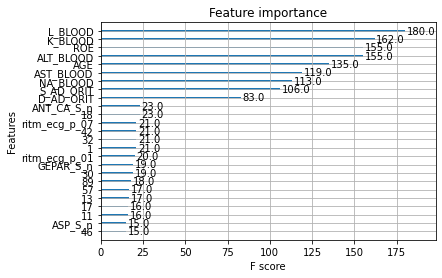

In [63]:
# plot feature importance
model = XGBClassifier()
model.fit(X_train, y_train)
plot_importance(model, max_num_features= 25)
pyplot.show()

In [64]:
# important 10 features
list_10 = [0,1,2,3,4,5,6,7,8,141]
X_train_important_10 = X_train[X_train.columns[list_10]]
X_test_important_10 = X_test[X_test.columns[list_10]]

In [65]:
# important 25 features
list_names_= ["ANT_CA_S_n","57","18","ASP_S_n","89","ritm_ecg_p_07","LID_S_n","1","90","16","11","SEX","13","42","GIPER_NA"] 
list_25 =[]
for x in list_names_:
    a = X_train.columns.get_loc(x)
    list_25.append(a)
print(list_25)
list_25 = list_10 + list_25
print(list_25)
X_train_important_25 = X_train[X_train.columns[list_25]]
X_test_important_25 = X_test[X_test.columns[list_25]]

[179, 66, 27, 181, 98, 145, 177, 10, 99, 25, 20, 110, 22, 51, 175]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 141, 179, 66, 27, 181, 98, 145, 177, 10, 99, 25, 20, 110, 22, 51, 175]


In [66]:
# tuning - 2 with 10 features
param_test1 = {
 'max_depth':range(3,25,1),
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train_important_10,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.48412256, 0.65701203, 0.77512102, 0.99500175, 1.11851835,
         1.36746907, 1.40278153, 1.51295834, 1.57830567, 1.55364003,
         1.72839727, 1.65452046, 1.77292175, 1.91386399, 1.75634289,
         1.72343163, 1.72393031, 1.84558396, 1.53666081, 1.88405738,
         1.92283502, 1.46338205]),
  'std_fit_time': array([0.01916639, 0.03481676, 0.06625364, 0.0431377 , 0.11335492,
         0.05201345, 0.0368747 , 0.07209452, 0.08712852, 0.12926755,
         0.12309262, 0.09079895, 0.06590175, 0.14162109, 0.13927911,
         0.19944252, 0.12745128, 0.07450795, 0.06380868, 0.08642028,
         0.22243102, 0.2439543 ]),
  'mean_score_time': array([0.00375323, 0.0036809 , 0.00324779, 0.00286584, 0.00322371,
         0.00351038, 0.00326381, 0.00341105, 0.00313973, 0.00309587,
         0.00358081, 0.00358109, 0.00471759, 0.00375595, 0.00338368,
         0.00529199, 0.00327058, 0.00397539, 0.00340776, 0.00359683,
         0.00331335, 0.00332427]),
  'std_score_ti

In [67]:
# tuning with 25 features
param_test1 = {
 'max_depth':range(3,25,1),
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train_important_25,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.58786302, 0.68109508, 0.85056758, 0.97507143, 2.10493274,
         1.91658978, 1.15262604, 1.39269495, 1.37443137, 1.45268397,
         1.38768101, 1.51990843, 1.43424869, 1.34815321, 1.40730104,
         1.55973444, 1.46724734, 1.5766458 , 1.55247746, 1.56827035,
         1.51438971, 1.16033969]),
  'std_fit_time': array([0.060096  , 0.03526319, 0.0744604 , 0.02920078, 0.94466614,
         0.99400818, 0.07851941, 0.10792451, 0.15436961, 0.10888604,
         0.11410906, 0.18278502, 0.056638  , 0.09279722, 0.09721138,
         0.0831437 , 0.12002748, 0.07694006, 0.11385286, 0.08121555,
         0.08420908, 0.29558802]),
  'mean_score_time': array([0.00289598, 0.0034112 , 0.00391784, 0.00385489, 0.00578957,
         0.00345373, 0.00342379, 0.00337915, 0.00350327, 0.00434747,
         0.00359063, 0.00394554, 0.00372915, 0.00421481, 0.00361509,
         0.00435138, 0.00459146, 0.00404382, 0.00364342, 0.00429711,
         0.00408354, 0.004494  ]),
  'std_score_ti

In [68]:
# tuning with all features
param_test1 = {
 'max_depth':range(3,25,1),
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.92718654, 1.00055265, 1.15262837, 1.31439538, 1.44504919,
         1.59889922, 1.69996328, 1.68246031, 1.7890501 , 1.874053  ,
         1.9055078 , 1.99964714, 1.94874463, 1.85441117, 1.96136866,
         2.02143898, 1.94018831, 2.07663856, 2.0097724 , 1.9080092 ,
         2.01992579, 1.81358962]),
  'std_fit_time': array([0.08268578, 0.08885693, 0.03964223, 0.0853785 , 0.07049958,
         0.09149703, 0.10319329, 0.07907756, 0.11529987, 0.07212572,
         0.16170543, 0.05606126, 0.14162613, 0.06027138, 0.08192188,
         0.04205536, 0.09864525, 0.13002772, 0.10711012, 0.11520756,
         0.18130275, 0.22152108]),
  'mean_score_time': array([0.00650601, 0.00614119, 0.00775261, 0.00664439, 0.00663781,
         0.00817041, 0.00778112, 0.00789819, 0.0072331 , 0.00746222,
         0.0066689 , 0.00747485, 0.00667725, 0.00738659, 0.00860405,
         0.00734386, 0.00742731, 0.00749741, 0.00736136, 0.00748534,
         0.00706739, 0.00734825]),
  'std_score_ti

In [69]:
# 10 features
# train
model = XGBClassifier(max_depth = 3)
model.fit(X_train_important_10, y_train)

# predict
y_pred = model.predict(X_test_important_10)
predictions = [round(value) for value in y_pred]

In [70]:
# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6011904761904762
Precision: 0.6307692307692307
Recall: 0.6648648648648648
F-measure: 0.6473684210526316


In [71]:
# 25 features
model = XGBClassifier(max_depth = 3)
model.fit(X_train_important_25, y_train)
y_pred = model.predict(X_test_important_25)
predictions = [round(value) for value in y_pred]

In [72]:
# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6220238095238095
Precision: 0.6559139784946236
Recall: 0.6594594594594595
F-measure: 0.6576819407008087


In [73]:
# all features
model = XGBClassifier(max_depth = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [74]:
# report performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-measure:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6755952380952381
Precision: 0.7065217391304348
Recall: 0.7027027027027027
F-measure: 0.7046070460704607


No Skill: ROC AUC=0.500
DT 15: ROC AUC=0.675
RF 20: ROC AUC=0.712


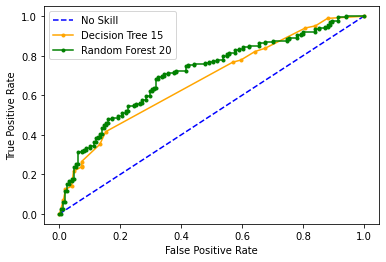

In [75]:
# roc curve and auc
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# train
train_model_dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)
train_model_dt.fit(X_train_15, y_train)
rf_model = RandomForestClassifier(max_depth=7, min_samples_leaf=15)
train_model_rf= rf_model.fit(X_train_20, y_train)

# predict
dt_probs = train_model_dt.predict_proba(X_test_15)
rf_probs= train_model_rf.predict_proba(X_test_20)

# keep positive outcomes
dt_probs = dt_probs[:, 1]
rf_probs = rf_probs[:, 1]

# calculate auc
ns_auc = roc_auc_score(y_test, ns_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('DT 15: ROC AUC=%.3f' % (dt_auc))
print('RF 20: ROC AUC=%.3f' % (rf_auc))

# calculate roc
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot roc curve
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', color='blue', label='No Skill')
pyplot.plot(dt_fpr, dt_tpr, marker='.', color='orange', label='Decision Tree 15')
pyplot.plot(rf_fpr, rf_tpr, marker='.', color='green', label='Random Forest 20')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()